# **IMPORTADO DE MÓDULOS/FUNCIONES**

In [32]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

In [33]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

data = np.load('/home/josea/PracticaTimingDigital/pulso_Co60_filt_norm.npz')
pulsos_Co60_practica_ = data['data']

In [34]:
from functions import get_mean_pulse_from_set, pulso, momentos, gauss, gauss_fit, delay_pulse_pair, move_to_reference, create_and_delay_pulse_pair, pulso_escalon, pulso_sigmoid
from Models import model_definition  

# **INTERPOLATION**

In [35]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28,  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55,  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82,  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


# **GENERATE MEAN PULSE PER DETECTOR**

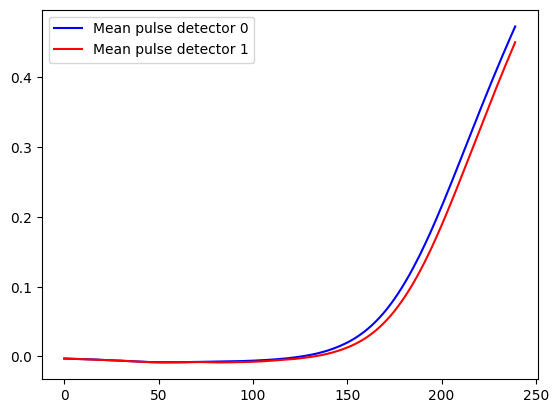

In [37]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_V55, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_V55, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING

plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

# **PREPROCESSING**

In [ ]:
#------------------------------------- Basic definitions ----------------------------------------
Ncasos = 300
Ncasos_mean = 100
Nc = 2

t = np.linspace(0,Nt,Nt_new)
#t0 = 65 + np.random.randint(5, size = Ncasos) 
t0 = 550 + np.random.randint(100, size = Ncasos)
#t0 = 78 + np.random.randint(5, size = Ncasos) 

In [38]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 3
tau_drop_dec0 = 150
Photon_yield = 100
center_window_dec0 = 0.3
rise_window_dec0 = 0.3

#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec1 = 3
tau_drop_dec1 = 150
Photon_yield = 100
center_window_dec1 = 0.3
rise_window_dec1 = 0.3

Text(0.5, 1.0, 'Detector 1')

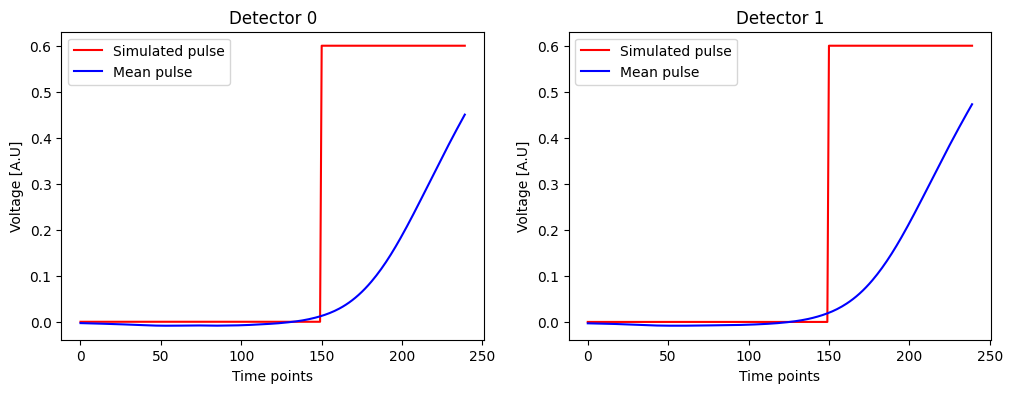

In [39]:
#pulso_original_dec0 = pulso(t,70, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0)
#pulso_original_dec1 = pulso(t, 70, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)
pulso_original_dec0 = pulso_escalon(t, 550, A = 0.6)
pulso_original_dec1 = pulso_escalon(t, 550, A = 0.6)
#pulso_original_dec0 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
#pulso_original_dec1 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = False)


#----------------------------------------- Plot -------------------------------------------------
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.plot(pulso_original_dec1[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec1[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')
plt.title('Detector 0')

plt.subplot(122)
plt.plot(pulso_original_dec0[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec0[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')
plt.title('Detector 1')

In [40]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Ncasos,Nt_new))
INPUT_dec1 = np.zeros((Ncasos,Nt_new))

for i in range(Ncasos):
  centro = t0[i]
  #PULSO = pulso(t, centro, tau_rise = tau_rise_dec0)
  #PULSO = pulso(t, centro, tau_rise = tau_rise_dec1)
  PULSO = pulso_escalon(t, centro, A = 0.6)
  PULSO = pulso_escalon(t, centro, A = 0.6)
  #PULSO = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
  #PULSO = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = False)
  INPUT_dec0[i,:] = PULSO
  INPUT_dec1[i,:] = PULSO

#------------------------------ Create copies of the mean pulse ----------------------------
INPUT2_dec0 = np.zeros((Ncasos_mean,len(mean_pulse_dec0)))
INPUT2_dec1 = np.zeros((Ncasos_mean,len(mean_pulse_dec1)))

#INPUT2_dec0[:,:] = np.roll(mean_pulse_dec0, -15)
#INPUT2_dec1[:,:] = np.roll(mean_pulse_dec1, -15)

In [41]:
#-------------------------------- Delay simulated pulses --------------------------------------------
INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(INPUT_dec0, new_time_step, delay_steps = 32, NOISE = True)
INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(INPUT_dec1, new_time_step, delay_steps = 32, NOISE = True)

#--------------------------------- Delay mean pulse ----------------------------------------------------
INPUT2_dec0, REF2_dec0 = create_and_delay_pulse_pair(INPUT2_dec0, new_time_step, delay_steps = 32, NOISE = True)
INPUT2_dec1, REF2_dec1 = create_and_delay_pulse_pair(INPUT2_dec1, new_time_step, delay_steps = 32, NOISE = True)

#--------------------------------- Create train set ----------------------------------------------------
trainX_dec0 = np.concatenate((INPUT_dec0[:,start:stop,:], INPUT2_dec0[:,start:stop,:]), axis = 0)
trainX_dec1 = np.concatenate((INPUT_dec1[:,start:stop,:], INPUT2_dec1[:,start:stop,:]), axis = 0)

REF_train_dec0 = np.concatenate((REF_dec0[:], REF2_dec0[:]))
REF_train_dec1 = np.concatenate((REF_dec1[:], REF2_dec1[:]))

Text(0.5, 1.0, 'Detector 1')

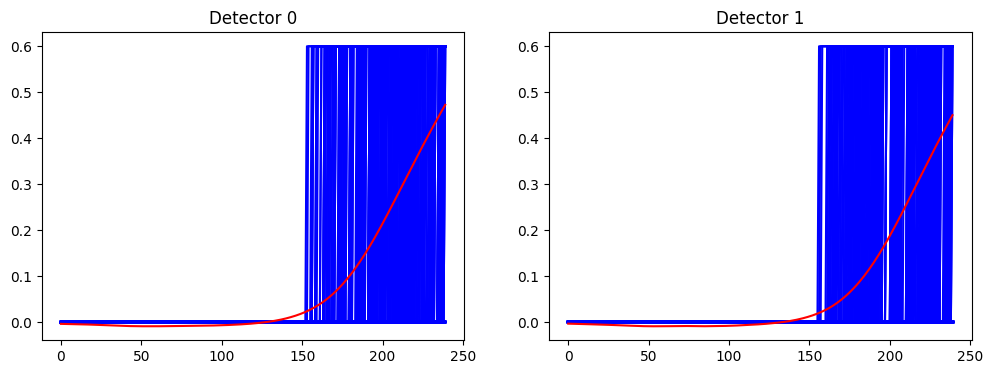

In [42]:
plt.figure(figsize = (12,4))

plt.subplot(121)
for i in range(trainX_dec0.shape[0]):
    plt.plot(trainX_dec0[i,:,0],'b-')
plt.plot(mean_pulse_dec0[start:stop], 'r-')
plt.title('Detector 0')

plt.subplot(122)
for i in range(trainX_dec0.shape[0]):
    plt.plot(trainX_dec1[i,:,0],'b-')
plt.plot(mean_pulse_dec1[start:stop], 'r-')
plt.title('Detector 1')

In [43]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)

min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

M_Train_dec0 = (M_Train_dec0-min_dec0)/(max_dec0 - min_dec0)


NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print('Min dec 0: ', min_dec0)
print('Max dec 0: ', max_dec0)

#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec1 = momentos(trainX_dec1)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec1 = (M_Train_dec1-min_dec1)/(max_dec1 - min_dec1)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print('Min dec 1', min_dec1)
print('Max dec 1', max_dec1)

(400, 12, 2) NM = 12
Min dec 0:  0.0
Max dec 0:  52.20000000000008
(400, 12, 2) NM = 12
Min dec 1 0.0
Max dec 1 53.400000000000084


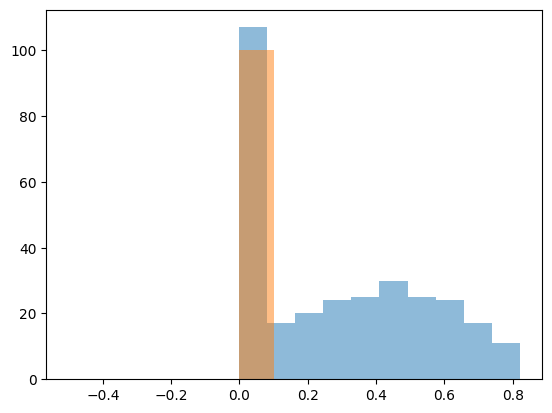

In [44]:
plt.hist(M_Train_dec0[:Ncasos,0,0], alpha = 0.5);
plt.hist(M_Train_dec0[Ncasos:,0,0], alpha = 0.5);

# **FULL TOF**

In [45]:
#--------------------------------- create reference set ------------------------------------------ 
REFERENCE_PULSE_dec0 = np.tile(mean_pulse_dec0[start:stop], (new_V82.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(mean_pulse_dec1[start:stop], (new_V82.shape[0],2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)

M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0-min_dec0)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1-min_dec1)

In [46]:
#--------------------------------- create test set ------------------------------------------ 
M_V28 = momentos(new_V28[:,start:stop,:])
M_V28[:,:,0] = (M_V28[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V28[:,:,1] = (M_V28[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V28.shape)

M_V55 = momentos(new_V55[:,start:stop,:])
M_V55[:,:,0] = (M_V55[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V55[:,:,1] = (M_V55[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V55.shape)

M_V82 = momentos(new_V82[:,start:stop,:])
M_V82[:,:,0] = (M_V82[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V82[:,:,1] = (M_V82[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V82.shape)


(187, 12, 2)
(268, 12, 2)
(281, 12, 2)


In [65]:
epochs = 100
num_semillas = 5

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(num_semillas):

  model_dec0 = model_definition(NM = NM, NN = 32, STD_INIT = 0.5)
  model_dec1 = model_definition(NM = NM, NN = 32, STD_INIT = 0.5)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate = 5e-5)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate = 5e-5)

  model_dec0.compile(optimizer = opt_dec0,loss = 'MSE')
  model_dec1.compile(optimizer = opt_dec1,loss = 'MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []

  for epoch in range(epochs):
     history_dec0 = model_dec0.fit(x = [M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]], y = REF_train_dec0, epochs = 3, batch_size = 64, shuffle = True, verbose = 1)
     history_dec1 = model_dec1.fit(x = [M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]], y = REF_train_dec1, epochs = 3, batch_size = 64, shuffle = True, verbose = 1)
     
     loss_dec0.append(history_dec0.history['loss'][-1])
     loss_dec1.append(history_dec1.history['loss'][-1])
     
     TOFN_dec0_REF_V82 = model_dec0.predict([M_V82[:,:,0], M_REF_dec0[:M_V82.shape[0],:,0]])
     TOFN_dec1_REF_V82 = model_dec1.predict([M_V82[:,:,1], M_REF_dec1[:M_V82.shape[0],:,0]])
     TOFN_dec0_REF_V55 = model_dec0.predict([M_V55[:,:,0], M_REF_dec0[:M_V55.shape[0],:,0]])
     TOFN_dec1_REF_V55 = model_dec1.predict([M_V55[:,:,1], M_REF_dec1[:M_V55.shape[0],:,0]])
     TOFN_dec0_REF_V28 = model_dec0.predict([M_V28[:,:,0], M_REF_dec0[:M_V28.shape[0],:,0]])
     TOFN_dec1_REF_V28 = model_dec1.predict([M_V28[:,:,1], M_REF_dec1[:M_V28.shape[0],:,0]])


     TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28
     TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
     TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82
    
     TOFN_V28_epoch.append(TOFN_V28)
     TOFN_V55_epoch.append(TOFN_V55)
     TOFN_V82_epoch.append(TOFN_V82)


     centroid_V28 = np.mean(TOFN_V28) - np.mean(TOFN_V55)
     centroid_V82 = np.mean(TOFN_V82) - np.mean(TOFN_V55)
     mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
     mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')


Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.4236
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 6.4065
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4020 
Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.0667
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 6.0454
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 6.0457
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 6.3941
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 6.3833
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 6.3718
Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 6.0229
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 6.0130
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 6.0118
9/9 ━━━━━━━

(array([4]), array([88])) 0.06650936682671553


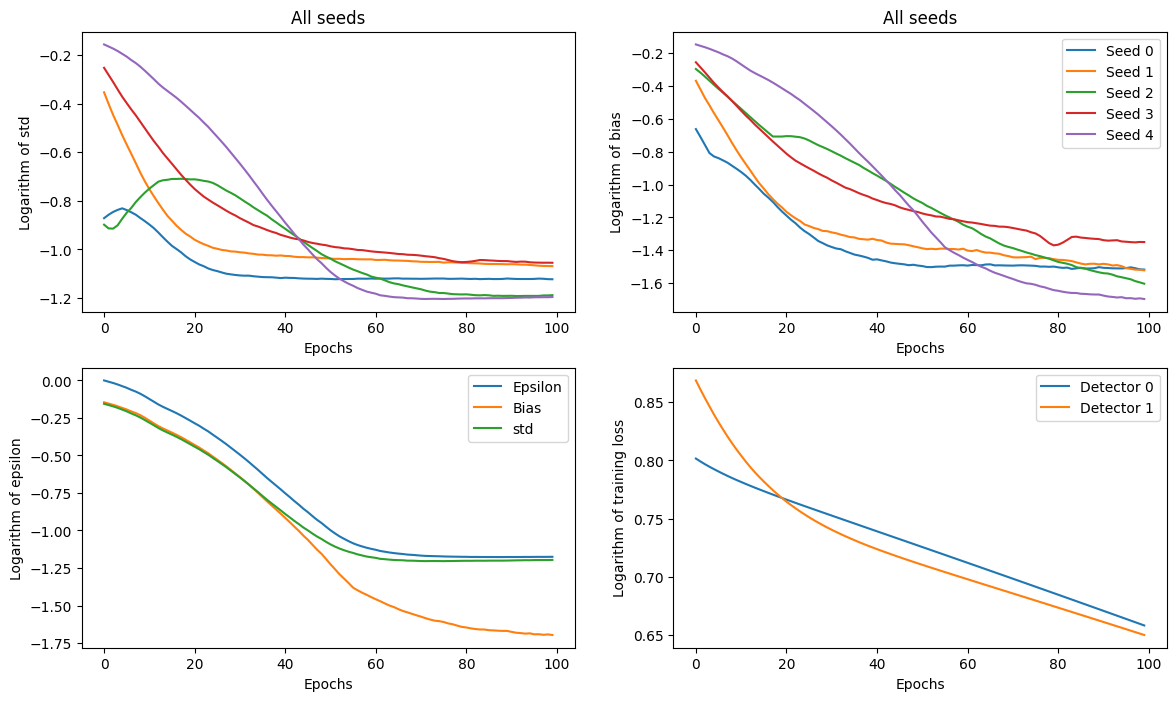

In [67]:
epsilon = np.array(epsilon, dtype = 'float64')
bias = np.array(bias, dtype = 'float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 4
plt.figure(figsize = (14,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  plt.plot(np.log10(std[i,:]))
plt.ylabel('Logarithm of std')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  plt.plot(np.log10(bias[i,:]), label = label)
plt.legend()
plt.ylabel('Logarithm of bias')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label = 'Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label = 'Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.169  FWHM(ns) = 0.141  std(ns) = 0.060
V55: CENTROID(ns) = 0.004  FWHM(ns) = 0.113  std(ns) = 0.048
V28: CENTROID(ns) = -0.171  FWHM(ns) = 0.164  std(ns) = 0.070


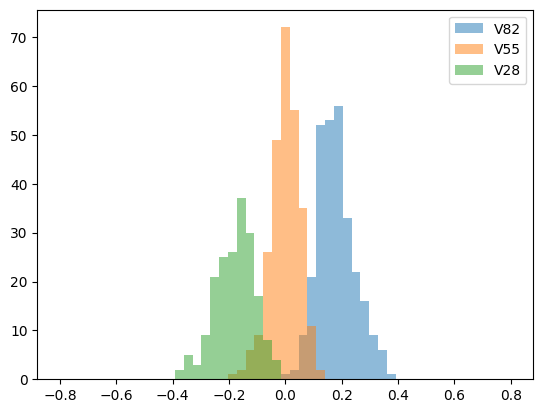

In [68]:
epoch = 88
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins = 51
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

In [69]:
Error_V82 = (TOFN_V82_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]) - 0.2)**2
Error_V55 = (TOFN_V55_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]))**2
Error_V28 = (TOFN_V28_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]) + 0.2)**2

Error = np.concatenate((Error_V82, Error_V55, Error_V28),axis=0)
MSE = np.mean(Error)   
print(MSE)                                                                                                               

0.00421342106074041


# **ENSEMBLE MODEL**

In [70]:
#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_V28 = np.average(np.squeeze(TOFN_V28_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V55 = np.average(np.squeeze(TOFN_V55_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V82 = np.average(np.squeeze(TOFN_V82_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)


V82: CENTROID(ns) = 0.156  FWHM(ns) = 0.154  std(ns) = 0.066
V55: CENTROID(ns) = 0.009  FWHM(ns) = 0.137  std(ns) = 0.058
V28: CENTROID(ns) = -0.196  FWHM(ns) = 0.205  std(ns) = 0.087


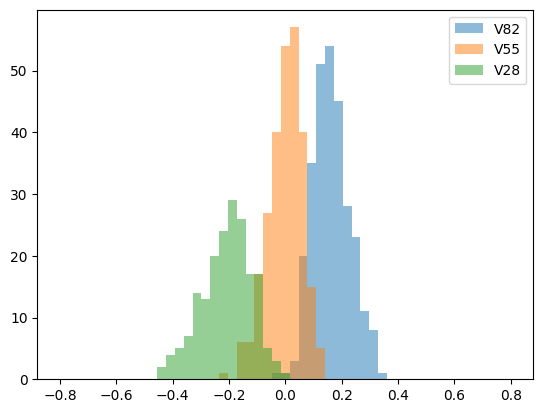

In [71]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(weighted_mean_V82 - np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(weighted_mean_V55 - np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(weighted_mean_V28 - np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))